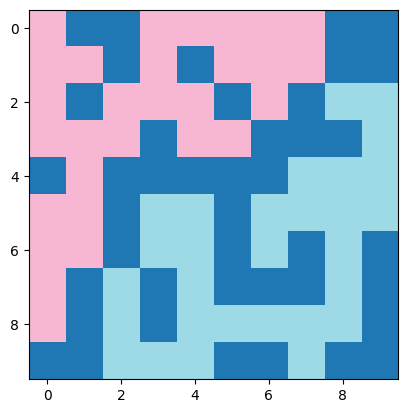

In [1]:
from matplotlib import pyplot as plt
import torch

@torch.compile
def find(x, labels):
    while torch.any(labels[x] != x):
        labels[x] = labels[labels[x]]  # path compression
        x = labels[x]
    return x.clone()

def union(x,y,labels):
    ind = find(x,labels)
    labels[ind]=find(y,labels)
    
def hoshen_kopelman(data):
    label = torch.zeros_like(data,dtype=torch.int32)
    largest_label = 0
    rows,cols = data.shape
    union_find_label = torch.arange(rows*cols,dtype=torch.int32)
    for x in range(rows):
        for y in range(cols):
            if data[x,y]==0: continue
            # one way is to make circular check
            left = label[(x-1)%rows,y]
            above = label[x,(y-1)%cols]
        
            #another way is to make bounded check
            # left = 0 if x-1<0 else label[x-1,y]
            # above = 0 if y-1<0 else label[x,y-1]
            
            if left==0 and above==0:
                largest_label+=1
                label[x,y]=largest_label
            elif left!=0 and above==0:
                label[x,y]=find(left,union_find_label)
            elif left==0 and above!=0:
                label[x,y]=find(above,union_find_label)
            else:
                union(left,above,union_find_label)
                label[x,y] = find(min(left,above),union_find_label)
    
    mask = data!=0
    label[mask]=find(label[mask],union_find_label)
    return label

data = 1*(torch.rand((10,10))>0.4)
clusters = hoshen_kopelman(data)

plt.imshow(clusters,cmap='tab20')